In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import string as string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
# uncomment if required
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')
# nltk.download('wordnet')

In [25]:
df = pd.read_csv('fake.csv')

In [26]:
#Create a new column 'post_engagement' which is the sum of the 'likes', 'comments', and 'shares' columns

sum_list = ['likes', 'comments', 'shares']
df['post_engagement'] = df[sum_list].sum(axis=1)

In [27]:
#Checking how many null entries in each column

df.isnull().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
post_engagement          0
dtype: int64

In [28]:
#Zooming in on "country" column, "US" is the most common entry

df.country.value_counts()

US    10367
GB      831
RU      400
DE      224
FR      207
TV      201
EU      112
CA      103
IS      100
ES      100
NL       55
ME       34
IN       23
BG       19
CO       17
LI       10
IR        7
EE        4
ZA        3
SG        2
IO        1
SE        1
AU        1
CH        1
Name: country, dtype: int64

In [29]:
#Filling null entries in "country" column with "US" as it is the most common

df.country.fillna("US", inplace=True)

In [30]:
#Remove countries that have less than 20 entries

value_counts = df.country.value_counts()
to_remove = value_counts[value_counts<20].index
df.replace(to_remove, np.nan, inplace = True)

In [31]:
df.language.value_counts()

english       12403
russian         203
spanish         172
german          111
french           38
arabic           22
portuguese       11
turkish          10
italian           9
ignore            7
greek             4
dutch             3
norwegian         3
finnish           1
chinese           1
polish            1
Name: language, dtype: int64

In [32]:
#Remove all non-english entries as there are too few

df = df[df.language == 'english']

In [33]:
#Dropping columns that will not be used

df = df.drop(['uuid', 'language', 'likes', 'comments', 'shares', 'crawled', 'published', 'ord_in_thread', 'domain_rank', 'main_img_url', 'thread_title'], axis = 1)

In [34]:
#Removing rows with missing values

df = df.dropna()

<AxesSubplot:>

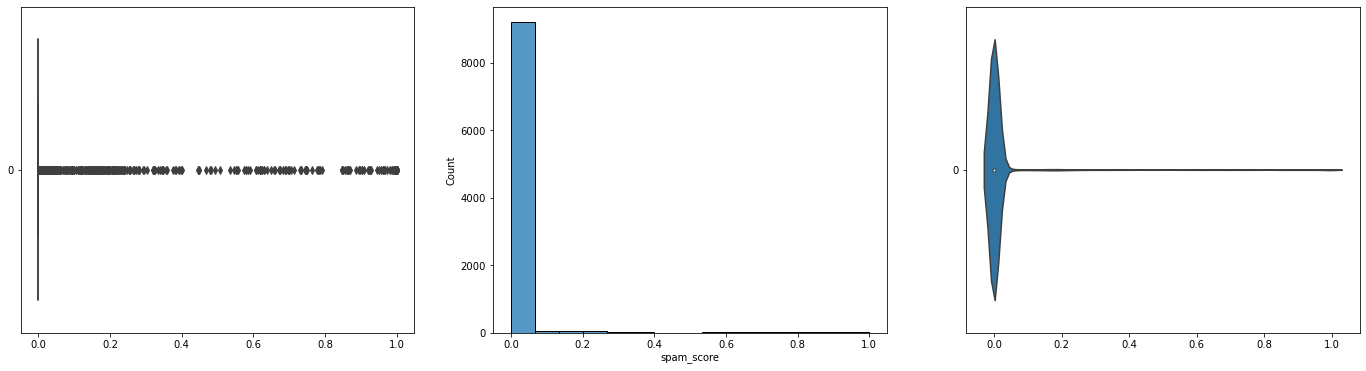

In [35]:
#Too many 0s for spam_score

f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = df.spam_score, orient = "h", ax = axes[0])
sb.histplot(data = df.spam_score, ax = axes[1])
sb.violinplot(data = df.spam_score, orient = "h", ax = axes[2])

In [36]:
#Remove 0 rows in spam_score to eliminate skewness (considering if we should remove the 0s?)

df = df[df.spam_score != 0]
spam = pd.DataFrame(df['spam_score'])

<AxesSubplot:>

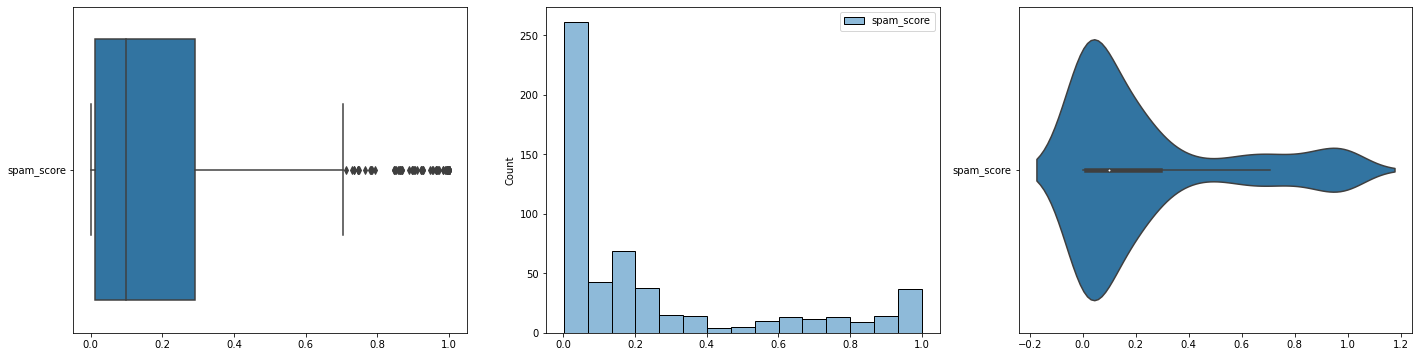

In [37]:
f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = spam, orient = "h", ax = axes[0])
sb.histplot(data = spam, ax = axes[1])
sb.violinplot(data = spam, orient = "h", ax = axes[2])

In [38]:
#Converting values of spam_score from numeric to categorical where 
#spam_score <= 0.3 is changed to 'low'
#0.3 < spam_score <= 0.6 is changed to 'medium'
#spam_score > 0.6 is changed to 'high'

df.loc[(df.spam_score <= 0.3) & (df.spam_score > 0), 'spam_score'] = 0.3
df.loc[(df.spam_score > 0.3) & (df.spam_score <= 0.6), 'spam_score'] = 0.6
df.loc[(df.spam_score > 0.6), 'spam_score'] = 1

df.loc[(df.spam_score == 0), 'spam_score'] = 'zero'
df.loc[(df.spam_score == 0.3), 'spam_score'] = 'low'
df.loc[(df.spam_score == 0.6), 'spam_score'] = 'medium'
df.loc[(df.spam_score == 1), 'spam_score'] = 'high'

In [39]:
spam = pd.DataFrame(df['spam_score'])

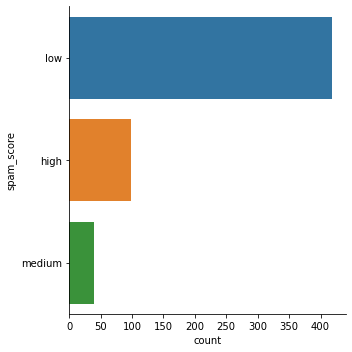

In [40]:
sb.catplot(y = "spam_score", data = spam, kind = "count")

In [41]:
#stop_words are the words that we ignore
 
stop_words = stopwords.words("english")

#function to tokenize text and remove stopwords, punctuations, non ascii characters

def stemmer(txt):
    txt=txt.lower()
    words = word_tokenize(txt)
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isascii()]
    return( " ".join(words ))

In [42]:
df["title"] = df["title"].apply(stemmer)
# df["text"] = df["text"].apply(stemmer)

In [43]:
txt = df["title"].tolist()
vectorizer = TfidfVectorizer()
vectorizer.fit(txt)

# dictionary of all the words in title can use to analyse with bar chart with high spam score
# https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary

mydict = vectorizer.vocabulary_

# to see count of "muslims"
# print("Count of 'muslims' in titles:", mydict["muslims"])

# to get top N most common words
import operator
mydict = dict( sorted(mydict.items(), key=operator.itemgetter(1),reverse=True))

n = 10

for i, (k, v) in enumerate(mydict.items()):
  if i == n: break
  print(k,":", v)

zionist : 2218
zika : 2217
zabivaka : 2216
yuge : 2215
yr : 2214
youtube : 2213
young : 2212
york : 2211
yet : 2210
yesterday : 2209


In [44]:
# NLP for machine learning
# https://medium.com/mlearning-ai/fake-news-data-analysis-and-predictions-with-machine-learning-83c2260a0491

vectorizer2 = TfidfVectorizer(min_df=2,ngram_range=(2, 3))
X_tfidf = vectorizer2.fit_transform(df['title'])
Xtfidf2 = vectorizer2.fit_transform(df['text'])